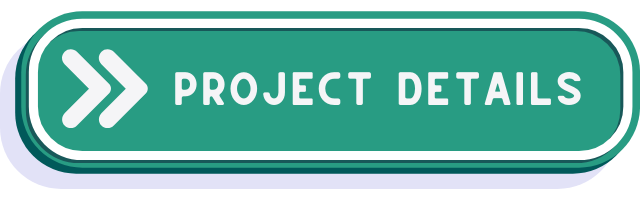

# About The Project

### Utah provides publicly accessible data on [**Police Cases between 2010-2014**](https://www.opendatanetwork.com/dataset/opendata.utah.gov/a56y-d97m), including details on case types, crime locations, and both 'Reported' and 'Closed' dates for each incident.

### The goal of this project is to perform an in-depth analysis of this data to uncover crucial insights that can enhance police policies, improve case processing times, and support targeted business actions to combat theft and bolster the local economy.

In [ ]:
# imports

import pandas as pd
import numpy as np

import regex
import json

import matplotlib.pyplot as plt
import seaborn as sns
# Set seaborn style
sns.set(style="whitegrid")

import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

import holidays


# Clear annoying package and version warnings
import warnings
warnings.filterwarnings('ignore')


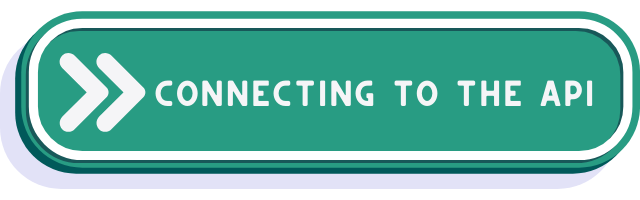

- Socrata provides plenty of documentation and code examples on their site https://dev.socrata.com


In [ ]:
# install required packages

!pip install sodapy

In [ ]:
# Import the Socrata library

from sodapy import Socrata

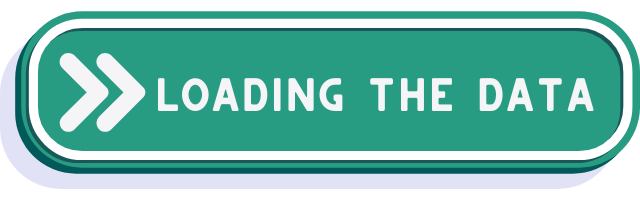

## Load the data from opendata.utah.gov

In [ ]:
# Maximize the output width
pd.set_option('display.max_colwidth', None)

# Initialise API

# A lot of the API endpoints can be used without an API key, but you might be throttled. You can signup for free and optain an API key pretty easily

# Use this for the free API access. (Free access has some limits)
client = Socrata("opendata.utah.gov", None)


# OR Use this with your actual API key information
# client = Socrata('opendata.utah.gov',
#                  'API_TOKEN',
#                  username='USERNAME',
#                  password='PASSWORD')


# Grab first 500 results, just to verify connection and json results
results = client.get('a56y-d97m', limit=500)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

results_df

In [ ]:
# There are 295925 rows. So lets grab ALL the data available
data = client.get('a56y-d97m', limit=295925)

df = pd.DataFrame.from_records(data)

df

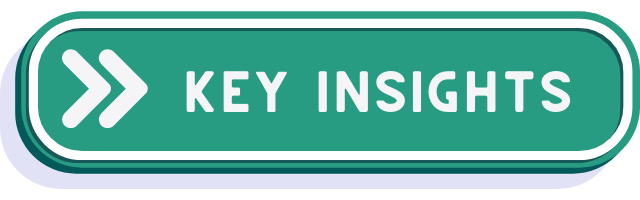

### Insights to look out for

- Count of each crime
- Worst Areas of crime: MAP **(we can do this easier in BI software)**
- Worst dates of crime
- Worst crime by year
- Worst and best day of the week
- Longest time from report date to closing date (Could look at this per crime)
- Seasonal Patterns: Investigate if crime rates vary by season or month

In [ ]:
df.dtypes

In [ ]:
df.isnull().sum()

In [ ]:
# Look at our Dates
df['report_date'].sort_values()

### Data says 2011-2014. But our Data goes back to January 2010. So we will treat it as 2010-2014.

In [ ]:
# The computed region codes seem to be for internal use, but I have no need for them so I will just drop them
# There are a few other columns I have no use for that I will also drop

df = df.drop(columns=[':@computed_region_9p4x_9cjt',
':@computed_region_dqjc_k29y',
':@computed_region_5phj_cc35',
':@computed_region_qmwn_impy',
'police_zone',
'police_grid',
 'council',
 'ibr_code',
 ])

df

In [ ]:
df.dtypes

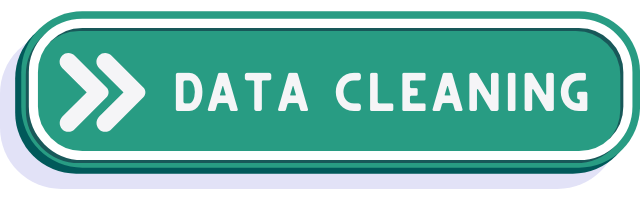

## Data Cleaning Steps

- **Deal with Duplicates:**
    - Identified and removed Duplicates that were not purposeful
- **Fix or Remove NA Values:**
    - Removed rows/columns with NA values
    - Separated data into two to track same day closing, and cases that took time to close
- **Correct Incorrect Data:**
    - Some cases were listed as ‘Closed’ before they were reported
- **Handling Missing Values:**
    - Missing values are different than NA values
    - Handled a few cases of missing data (2015 was removed as it only had under 100 cases total and would skew yearly results)
- **Fix Data Types:**
    - Converted all dates to date types
    - Converted location data to longitude and latitude for mapping
- **Fix Column Names:**
    - Standardizes column names and removed for easier understanding
    - Removed irrelevant columns to simplify the data we are working with
- **Handling Outliers:**
    - Used Interquartile Range (IQR) to identify outliers
    - Split data in two with and without outliers to identify their significance
- **Standardizing Formats:**
    - Ensure consistency in date formats and numerical formats for graphing and calculations
- **Data Validation:**
    - Performed consistency checks to verify data
- **Data Aggregation:**
    - Grouped data by Crime and by dates to discover trends
    - Aggregate existing data to create new values to help identify trends
- **Documenting Data Cleaning Steps:**
    - Keep a record of the data cleaning steps performed to ensure reproducibility and to provide clarity for your future self or other team members.


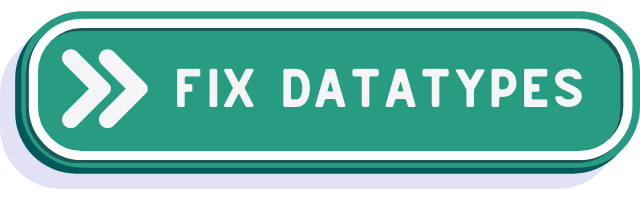

## Let's fix our datatypes

- both date columns should be dates, and day of the week we may want to convert to READ out the day of the week

#### Days of the week should read out as the actual day, not numerical

- We can create a dictionary to re-assign all the values

In [ ]:
df['day_of_week'].value_counts()

In [ ]:
# I verified several days in the data to create this mapping

days_of_week = {
    '1': 'Sunday',
    '2': 'Monday',
    '3': 'Tuesday',
    '4': 'Wednesday',
    '5': 'Thursday',
    '6': 'Friday',
    '7': 'Saturday'
}


df['day_of_week'] = df['day_of_week'].map(days_of_week)

df

In [ ]:
df['day_of_week'].value_counts()

In [ ]:
# Convert to just date without the timestamp
df['occ_date'] = pd.to_datetime(df['occ_date']).dt.date
df['report_date'] = pd.to_datetime(df['report_date']).dt.date

# set datatype as datetime
df['occ_date'] = pd.to_datetime(df['occ_date'])
df['report_date'] = pd.to_datetime(df['report_date'])

df.dtypes

In [ ]:
df.dropna()

df

In [ ]:
# Lets rename columns for readability

df = df.rename(columns={"ucr_code": "crime_code", "ucr_description": "crime_description", "occ_date": "closed_date"})

In [ ]:
# Extract month and Year
df['month'] = df['report_date'].dt.to_period('M')

df['year'] = df['report_date'].dt.to_period('Y')

df

In [ ]:
df['year'].value_counts()

In [ ]:
df['year'].value_counts().mean()

### The year 2025 is incomplete, so lets remove it from our data

In [ ]:
df = df.loc[df['year'] != '2015']

df = df.reset_index(drop=True)

df

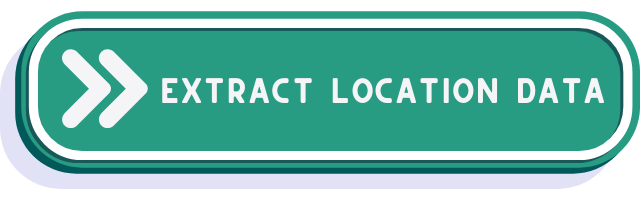

### I want to extract the latitude and longitude data from the 'location_1' column

In [ ]:
location_df = df


# Extract the json data from 'location_1'
location_data = pd.json_normalize(location_df['location_1'])

# Combine with the original Data
location_df = location_df.join(location_data)

# Drop the columns we dont need
location_df = location_df.drop(columns=['location_1', 'human_address', 'year', 'month'])

location_df

In [ ]:
# drop our now unused column and split long and lat data from our main dataframe
df = df.drop(columns='location_1')


# We can store location data in just our location df, and keep the Case # as the key to pair with our original data
location_df = location_df.drop(columns=['crime_code', 'closed_date', 'day_of_week']).reset_index(drop=True)

### we still have some NA values in our location df that weren't filtered when we copied the df.

- Lets remove those now since this location_df is only being used to do analysis on locations. 


In [ ]:
location_df = location_df.dropna().reset_index(drop=True)

location_df

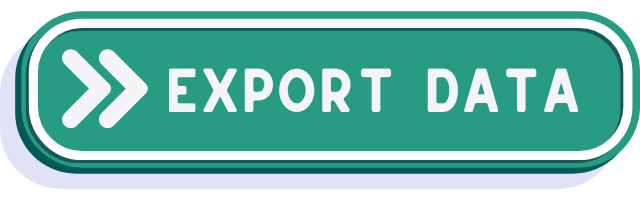

In [ ]:
# Export the data so I can use the lat and long data to map the locations
location_df.to_csv('crime_locations.csv') 

### Focus back on our main df

In [ ]:
df.isna().sum()

In [ ]:
df

In [ ]:
# Lets drop our NA values from the report date, there arent that many so we can actually improve the data by removing them

df = df.dropna(subset=['report_date']).reset_index(drop=True)
df

In [ ]:
# Count of each crime

df['crime_description'].value_counts().reset_index()

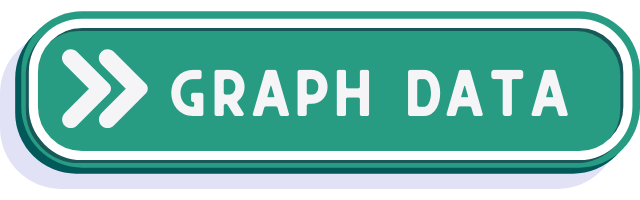

## Graph and visualize the data

### What was the highest total crime for each year?

In [ ]:
crime_by_year = df.groupby(['year', 'crime_description']).size().reset_index(name='count')

# Sort by year and count in descending order
sorted_crime_by_year = crime_by_year.sort_values(by=['year', 'count'], ascending=[True, False])

# Get the top crime for each year
top_crime_by_year = sorted_crime_by_year.groupby('year').first().reset_index()

top_crime_by_year

### Basic visualizations to show the Worst dates for crime
- We could get as specific as we want here, but lets just do counts overall. 
- When we make our interactive dashboard we can dive deeper into the data

In [ ]:
# Worst dates
crime_by_date = df.groupby('report_date').size().reset_index(name='crime_count')

# Sort by count
worst_date = crime_by_date.sort_values(by='crime_count', ascending=False)

# Get the top 10 worst dates
top_date = worst_date.head(10)


# Plot the top 10 worst dates
plt.figure(figsize=(12, 6))
plt.bar(top_date['report_date'].astype(str), top_date['crime_count'])
plt.ylabel('Total Crimes')
plt.title('Worst Dates for Crime')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Worst Month of crime

# Count the number of crimes per month
crime_by_month = df.groupby('month').size().reset_index(name='crime_count')

# Sort by the number of crimes
worst_months = crime_by_month.sort_values(by='crime_count', ascending=False)


# Plot the top 10 worst months
top_months = worst_months.head(10)

plt.figure(figsize=(12, 6))
plt.bar(top_months['month'].astype(str), top_months['crime_count'])
plt.ylabel('Total Crimes')
plt.title('Worst Month for crime')
plt.xticks(rotation=45)
plt.show()

### August seems to be a particularly bad month for crime having top numbers across multiple years

- August also appeared 6 times in our top 10 worst dates overall

In [ ]:
# Worst day for crime

# Count the number of crimes per day of the week
crime_by_day = df.groupby('day_of_week').size().reset_index(name='crime_count')

# Sort by the number of crimes
worst_day = crime_by_day.sort_values(by='crime_count', ascending=False)

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(worst_day['day_of_week'].astype(str), worst_day['crime_count'])
plt.ylabel('Total Crimes')
plt.title('Worst Day of the Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Worst Year of crime

# Count the number of crimes per year
crime_by_year = df.groupby('year').size().reset_index(name='crime_count')

# Sort by the number of crimes
worst_years = crime_by_year.sort_values(by='crime_count', ascending=False)


# Plot the top 5 worst tear
top_months = worst_years.head(5)

plt.figure(figsize=(12, 6))
plt.bar(top_months['year'].astype(str), top_months['crime_count'])
plt.ylabel('Total Crimes')
plt.title('Worst Year for crime')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Reformat 'year' is an integer for our next graph

crime_by_year['year'] = crime_by_year['year'].dt.year
crime_by_year['year'] = crime_by_year['year'].astype(int)

In [ ]:
# Find the worst year (year with the HIGHEST number of crimes)
worst_year = crime_by_year.loc[crime_by_year['crime_count'].idxmax()]

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(crime_by_year['year'], crime_by_year['crime_count'], marker='o', linestyle='-', label='Crimes per Year')

# Highlight the worst year
plt.scatter(worst_year['year'], worst_year['crime_count'], color='darkred', zorder=5, label=f'Worst Year: {worst_year["year"]}')

# labels and title
plt.xlabel('') # I dont want the 'year' label since this data is obvious
plt.ylabel('Total Crimes')
plt.title('Crimes per Year')

# matplot is trying to split years into half years, so lets fix this so we only see full years
plt.xticks(ticks=crime_by_year['year'], rotation=45)

plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
df

### What is the longest gap from crime reported date and the case being closed?

- We can easily calculate this by finding the difference between report date and closed date

### What is the Slowest crime from report to closing


In [ ]:
# Calculate the case duration
df['case_duration'] = (df['closed_date'] - df['report_date']).dt.days

# Drop na rows
df = df.dropna().reset_index(drop=True)

# Making it int to get rid of the annoying trailing .0 (We only want whole days, no half or fractional days)
df['case_duration'] = df['case_duration'].astype(int)

# View the 10 slowest crimes
df.sort_values(by='case_duration', ascending=False).head(10)

### Fraud is the slowest when it comes to closing the case
- lets see if we can find the top 5 crimes that take the longest

<hr>

### What are the top 5 slowest crimes from reporting to closing?

In [ ]:
# Find the 5 slowest to close crimes when it comes to case_duration
case_durations = df.groupby('crime_description')['case_duration'].max().reset_index().round(2)

# Sort the results
case_durations.sort_values(by='case_duration', ascending=False).head(5)

### These are the individual longest cases
- We will calculate the average closing next

In [ ]:
df

### Lets check if cases reported on friday or saturday had a higher average closing date 
- Most would assume the weekend took longer to process it vs crimes during the regular week

### We could also check dates around the holidays to see if that impacted the closing speed

### How does the amount of reports currently reported affect the amount of tie it takes to close cases?

- Correlate amount of cases per month to the amount of time it takes to close cases

In [ ]:
# Filter out cases that were closed same_day
df_filtered = df[df['case_duration'] > 0]

df_filtered.groupby('day_of_week')['case_duration'].max().sort_values(ascending=False)

# This shows the highest individual cases on each day

In [ ]:
df_filtered.groupby('day_of_week')['case_duration'].mean().round(2).sort_values(ascending=False)

# This shows the average case closing time for crimes report on the specified day

In [ ]:
df_filtered.groupby('day_of_week')['case_duration'].sum().sort_values(ascending=False)

# Calculates the total time to close cases that were reported on the specified day

In [ ]:
# Define range to pull holidays from
years = range(2010, 2014)

holiday_dates = []

# Loop through the years and get holidays
for year in years:
    us_holidays = holidays.US(years=year)
    holiday_dates.extend(list(us_holidays.keys()))


df_holidays = pd.DataFrame(holiday_dates, columns=['holiday_date'])
df_holidays['holiday_date'] = pd.to_datetime(df_holidays['holiday_date'])

# Convert holiday_dates to a set for faster lookup
holiday_dates = set(df_holidays['holiday_date'].dt.strftime('%Y-%m-%d'))

# Create a column indicating if the date is a holiday
df_filtered['is_holiday'] = df_filtered['report_date'].dt.strftime('%Y-%m-%d').isin(holiday_dates)


# Calculate average case duration for holidays and non-holidays
avg_case_duration_holidays = df_filtered[df_filtered['is_holiday']]['case_duration'].mean().round(2)
avg_case_duration_non_holidays = df_filtered[~df_filtered['is_holiday']]['case_duration'].mean().round(2)


print('Results do not include cases closed on sameday as reported')
print('Results:')
print(f"Average case duration on holidays: {avg_case_duration_holidays}")
print(f"Average case duration on non-holidays: {avg_case_duration_non_holidays}")

### According to the data cases reported on saturday and sunday actually closed faster than any other day

- Sunday and saturday also had the lowest amount of reported cases so they are more susceptible to outliers

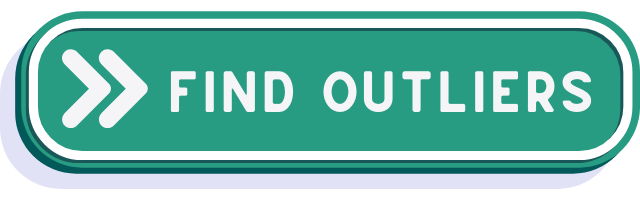

## Outliers

### Before we assume all of the results we just looked at... lets double check if there are outliers skewing our results
- We can use Interquartile Range (IQR) to check for outliers
    - The Interquartile Range (IQR) is the range between the third quartile and the first quartile. It measures the spread of the middle 50% of the data.
    
### The formula for the IQR is: 
### <code> \(IQR=Q3-Q1\) </code>

In [ ]:
# use IQR to check for outliers in the Days data


def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Detect outliers in case duration
outliers = detect_outliers(df, 'case_duration')

filtered_outliers = detect_outliers(df_filtered, 'case_duration')

# Summary Statistics
num_outliers = len(filtered_outliers)
avg_duration_outliers = filtered_outliers['case_duration'].mean()
min_duration_outliers = filtered_outliers['case_duration'].min()
max_duration_outliers = filtered_outliers['case_duration'].max()

# Print Summary
print("Outliers Summary:")
print(f"Number of outliers: {num_outliers}")
print(f"Average case duration of outliers: {avg_duration_outliers:.2f}")
print(f"Minimum case duration of outliers: {min_duration_outliers}")
print(f"Maximum case duration of outliers: {max_duration_outliers}")


### Looking at this we can see the Zeroes were never the issue. We have outliers skewing our results.
- We can either deal with the outliers directly (By removing them from the df
- Or we can leave the outliers inplace and calculate our data around them

In [ ]:
# Calculate average case duration with outliers
avg_case_duration_all = df['case_duration'].mean().round(2)

# Filter out outliers
df_without_outliers = df[~df['case_duration'].isin(outliers['case_duration'])]

# Calculate average case duration without outliers
avg_case_duration_no_outliers = df_without_outliers['case_duration'].mean().round(2)

print(f"Average case duration (with outliers): {avg_case_duration_all}")
print(f"Average case duration (without outliers): {avg_case_duration_no_outliers}")


In [ ]:
df[df['case_duration'].isin(outliers['case_duration'])]

In [ ]:
df[df['case_duration'] < 0].reset_index(drop=True)

### We have 24927 total outliers, and 19465 of those the case was closed before it was even reported. Without having access to more information we cannot detirmine why that is the case
- Lets remove SOME outliers from our data
    - Instead of removing ALL outliers, I only want to remove the troublesome data with cases reporting closed BEFORE the report date


In [ ]:
df = df[~df['case_duration'] < 0].reset_index(drop=True)

df

### After removing outliers we are left with 216118 rows of data. 
- We started with 295925 rows. So we have dropped 79807 of na, outliers, and incomplete data.
- This is a significant amount and we may want to think about keeping more data and instead fixing the values instead of removing them

In [ ]:
# Calculate average case duration without outliers
avg_case_duration = df['case_duration'].mean().round(2)

print('Average case durations:')
print()
print(f"Original avg with all outliers: {avg_case_duration_all}")
print(f"avg without ANY outliers: {avg_case_duration_no_outliers}")
print(f"avg with negative durations removed: {avg_case_duration}")

### Removing the outliers definitely helps with the issue... but it does not fix how many 'Same_day' cases we have skewing our average results

- We need to do our best as analysts to Clean and prepare the data to the best of our ability.
- Removing these outliers is just one of MANY steps to getting more accurate reporting and making more accurate data-driven decisions. 

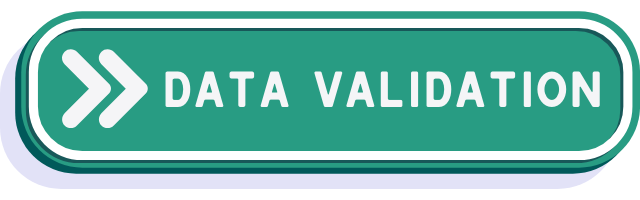

## After we removed outliers
- Now that we have removed the outliers lets look at tour data again
- We can do this a few different ways, for now I am just going to copy a few blocks to check the results right here


In [ ]:
# Calculate data including the zeroes

count_by_day_zeroes = df.groupby('day_of_week')['case_duration'].max().sort_values(ascending=False)
avg_by_day_zeroes = df.groupby('day_of_week')['case_duration'].mean().round(2).sort_values(ascending=False)
total_cases_by_day_zeroes = df.groupby('day_of_week')['case_duration'].sum().sort_values(ascending=False)

In [ ]:
# Calculate data without zeroes

count_by_day = df_filtered.groupby('day_of_week')['case_duration'].max().sort_values(ascending=False)
avg_by_day = df_filtered.groupby('day_of_week')['case_duration'].mean().round(2).sort_values(ascending=False)
total_cases_by_day = df_filtered.groupby('day_of_week')['case_duration'].sum().sort_values(ascending=False)


In [ ]:
# How many same day cases do we have??

len(df[df['case_duration'] == 0])

In [ ]:
# How many cases do we have that take longer than 1 day to close??

len(df[df['case_duration'] != 0])

### Results With same_day cases 

In [ ]:
print(f"Avg case durations: \n  {avg_by_day_zeroes}")

### Results Without zeroes(same_day) cases 

In [ ]:
print(f"Avg case durations: \n  {avg_by_day}")

### According to the data with outliers removed, cases reported on saturday and sunday are still teh fastest from report to close

- These cases still have the lowest total number, which might indicate that cases are being processed as they are reported. 
- Because these cases have the lowest number of reports, they could be reviewed and handled more quickly.

### Worst day for each crime reported

In [ ]:
# group the crimes by day
count_crimes_by_day = df.groupby('crime_description')['day_of_week'].value_counts().reset_index()

# Find the day with the max count for each crime
max_count_days  = count_crimes_by_day.loc[count_crimes_by_day.groupby('crime_description')['count'].idxmax()]

# save 10 worst crimes for use later
worst_crime_days = max_count_days
worst_crime_days = worst_crime_days.sort_values('count', ascending=False).head(10)

# sort and display the results for each crime
max_count_days.sort_values('count', ascending=False)

In [ ]:
# Function to get top two days
def get_top_two_days(group):
    sorted_group = group.sort_values(by='count', ascending=False)
    top_two = sorted_group.head(2)
    return pd.Series({
        'worst_day': top_two.iloc[0]['day_of_week'],
        'worst_count': top_two.iloc[0]['count'],
        'second_worst_day': top_two.iloc[1]['day_of_week'] if len(top_two) > 1 else None,
        'second_worst_count': top_two.iloc[1]['count'] if len(top_two) > 1 else None
    })

# Apply the function to see both worst and second worst days for each crime
results = count_crimes_by_day.groupby('crime_description').apply(get_top_two_days).reset_index()

# remove rows that have no second worst day
filtered_results = results[results['second_worst_count'].notna()]

# fix the float values to in so there is no ugly trailing .0
filtered_results['second_worst_count'] = filtered_results['second_worst_count'].astype(int)

# Sort the results by counts
filtered_results.sort_values('worst_count', ascending=False).reset_index(drop=True)

In [ ]:
# Compare worst crime days overall VS the worst crime days for the top 10 worst crimes

worst_crime_days

In [ ]:
worst_days_overall = df['day_of_week'].value_counts().sort_values(ascending=False).reset_index()

worst_days_overall

In [ ]:
df_seasonal = df

df_seasonal

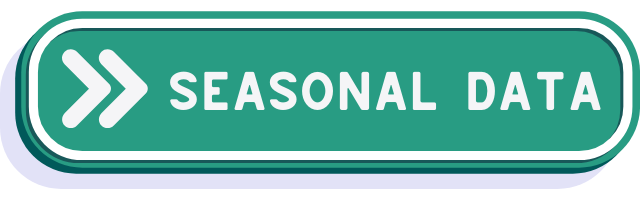

## Data separated by Seasons

In [ ]:
# Define function to assign seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

# Transform month to just be the month number
df_seasonal['month'] = df_seasonal['report_date'].dt.month

# Apply the function to assign season values to each row
df_seasonal['season'] = df_seasonal['month'].apply(get_season)

df_seasonal

In [ ]:
crimes_by_season = df_seasonal.groupby('season').size().reset_index(name='total_crimes')

crimes_by_season.sort_values('total_crimes', ascending=False).reset_index(drop=True)

In [ ]:
# Group crimes by season
crime_counts = df_seasonal.groupby(['season', 'crime_description']).size().reset_index(name='count')

# Sort by season, and then count
crime_counts = crime_counts.sort_values(by=['season', 'count'], ascending=[True, False])

# Get top 3 crimes for each season
top_3_crimes_per_season = crime_counts.groupby('season').head(3).reset_index(drop=True)

top_3_crimes_per_season

In [ ]:
# Create a bar plot
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    x='season',
    y='count',
    hue='crime_description',
    data=top_3_crimes_per_season,
    dodge=True
)

# Add counts above each bar
for p in ax.patches:
    
    # Get the values from each bar
    height = p.get_height()
    
    # This little codeblock can be found on Stackoverflow. Why reinvent the wheel??
    ax.text(
        p.get_x() + p.get_width() / 2,  # center over the bar
        height + 0 * height,  # Set text just above the bar
        f'{int(height)}',  # use the count as the text
        ha='center',
        va='bottom'
    )
    

# titles and labels
plt.title('Top 3 Crimes by Season', fontsize=16)
plt.xlabel('Season')
plt.ylabel('Total Crimes')
plt.legend(title='Crime Description', bbox_to_anchor=(1.05, 1), loc='upper left') # Even though it says upper left. seaborn wraps it off to the right and it looks nicest right there
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
df['location'].value_counts()

In [ ]:
df['location'].str.contains('HOPE AVE', case=False, na=False).value_counts()

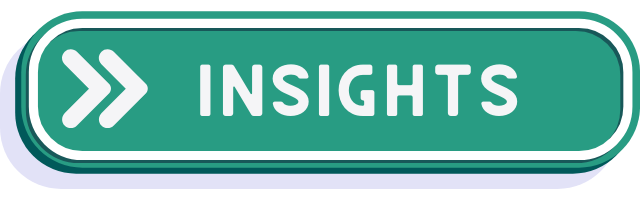

# Insights:

> **Reminder:** 
Data only includes reported crime in Salt Lake City between the years 2010 and 2014.
> 

The dataset reveals a broad range of different crimes, with **LARCENY** being the most frequent, followed by **PUBLIC ORDER** and **TRAFFIC** offenses.

*The total number of recorded crimes varies significantly by type, indicating diverse criminal activities.*

### **Crime Trends by Day of the Week**

### Larceny on Mondays
- **Observation:** Larceny incidents peak on Mondays with 5,907 occurrences.
- **Possible Explanation:** The start of the workweek may create opportunities for looting as people return to their routines. The increased activity and busier environments on Mondays might be exploited by criminals.

### Traffic and Public Order Crimes on Fridays
- **Observation:** Traffic violations and public order crimes are highest on Fridays, with counts of 5,282 and 5,223, respectively.
- **Possible Explanation:** The end of the workweek often brings relaxed attitudes and increased social activities, potentially leading to more traffic offenses and public disturbances.

### Public Peace Crimes on Thursdays
- **Observation:** Public peace crimes are most frequent on Thursdays, totaling 2,722 incidents.
- **Possible Explanation:** Midweek stress and tension may contribute to disturbances. Additionally, increased socialization on Thursday evenings might lead to more public peace violations.

### Assaults on Saturdays
- **Observation:** Assault incidents are notably high on Saturdays with 2,508 reported cases.
- **Possible Explanation:** Weekend social activities and parties often lead to increased alcohol consumption and potential conflicts, resulting in a higher incidence of assaults.

### Weekend Crime Trends
- **Observation:** Saturdays and Sundays show elevated counts for crimes such as assault, robbery, and sexual offenses.
- **Possible Explanation:** Social gatherings and increased interactions over the weekend may contribute to higher crime rates, including violence and sexual offenses.

### Midweek Trends
- **Observation:** Wednesdays have significant counts for liquor-related offenses, property crimes, and various other offenses.
- **Possible Explanation:** Midweek social dynamics and routines might influence specific crime types differently compared to weekends.

### Longest and Average Case Processing Times

**98%** of cases are closed the same day they’re reported, while **5,462 cases took more time to process**

- **FRAUD** cases have the longest processing time, with the longest taking **1770 days** to be closed
- **EXPLOITATION** cases have the highest **average of 231 days** from report to close

### Seasonal Patterns

**Summer** has the highest crime count.

- **Possible Explanation:** The summer is the most common time for personal activities. With so many people away from school and their regular routines it could possibly explain why most crime is reported in the summer.

*The data suggests seasonal variation in crime rates, with different types of crimes peaking in specific seasons.*



## ✅ Recommendations


> Based on the data, here are a few targeted recommendations for the state to consider:
> 
1. **Enhance Security for High-Crime Days and Areas**
    - **Targeted Security:** Implement heightened security measures on Mondays (for larceny) and Saturdays (for assaults). Increase security personnel, especially in high-crime areas like Hope Ave and around popular business zones.
    - **Community Engagement:** Develop community outreach programs to foster collaboration among local businesses. This can create a business watch network that enhances safety and makes Salt Lake City a more attractive location for new businesses.
    
2. **Invest in Fraud and Embezzlement experts**
    - **Fraud Prevention Programs:** Invest in internal experts, as these complex cases have long processing times. This will help prevent and address local business more effectively, protecting our local economy from additional financial loss.
    - **Education and Awareness:** Conduct workshops or informational sessions for local employees and customers on how to recognize and report suspicious activities. This can help in reducing incidents and speeding up case resolutions.
3. **Leverage Technology**
    - **Advanced Surveillance:** Invest in surveillance technology and analytics to better monitor crime trends and respond quickly. Technologies such as AI-driven analytics can help identify patterns and potential threats more efficiently.
    - **Data Analysis Tools:** Use data analysis tools to continuously monitor and assess crime trends in relation to local business operations. This will help in making informed decisions about security and operational adjustments in our area.

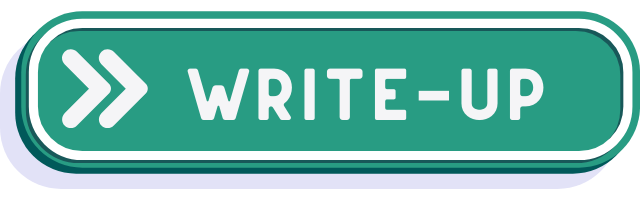

## Full Write-up Report

### [Data Report](https://www.canva.com/design/DAGQ3-L9EaI/pbXbXFWactecFB4y8hVrIg/view) 

### [Notion write-up](https://camdoesdata.notion.site/SLC-Crime-Data-25cb7fa1c63f43a1ace9960ebfc9a5e9?pvs=74)

### [Tableau Map](https://public.tableau.com/views/SLCCrimeReports2010-2014/Dashboard1?:language=en-US&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link)

### [Github Repo](https://github.com/CameronCSS/SLC-Police-Cases-2010-2014/blob/main/README.md)